![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

## Case study 2: Hello worlds. Run two models on the same forcing data and compare output (discharge)
This notebooks demonstrates how to use models in eWaterCycle by showing how to run two different models for the same region (Merrimack) and on the same forcing data (ERA5: 1990). In this notebook, in contrast with the `Case1_Marrmot_Merrimack_ESMValTool` notebook, two distributed models are used. 

The models used in this notebook are:

- WFlow (Schellekens et. al. 2020, [https://doi.org/10.5281/ZENODO.593510](https://doi.org/10.5281/ZENODO.593510))
- LISFLood (van der Kneijf et. al. 2010, [https://doi.org/10.1080/13658810802549154](https://doi.org/10.1080/13658810802549154))

The pre-processing (ie. generating forcing data) for this experiment was already done. For information on how to generate forcing data for a given combination of model, forcing dataset and time period, see the notebook titled `Case1_Marrmot_Merrimack_ESMValTool` in this repo.

## Import statements
We'll be using the following modules

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
from cartopy.io import shapereader
from rich import print

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.analysis
import ewatercycle.observation.grdc
import ewatercycle.parameter_sets

## Experiment settings
Just like in `Case1_Marrmot_Merrimack_ESMValTool` the Merrimack will be used. 

In [8]:
experiment_start_date = "1990-01-01T00:00:00Z"
experiment_end_date = "1990-12-31T00:00:00Z"

# GRDC observation station for Merrimack river
grdc_station_id = "4147380"

## Observation

In [9]:
# Get grdc observations at 4147380 station related to Merrimack
df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=experiment_start_date,
    end_time=experiment_end_date,
)

# Get lat/lon of the station
station_lat = [metadata["grdc_latitude_in_arc_degree"]]
station_lon = [metadata["grdc_longitude_in_arc_degree"]]

# Convert it to dataframe and rename it to GRDC
observations = df.rename(columns={"streamflow": "GRDC"})
observations

,GRDC
time,
1990-01-01,119.214
1990-01-02,136.204
1990-01-03,131.107
1990-01-04,133.655
1990-01-05,139.035
...,...
1990-12-27,668.276
1990-12-28,512.534
1990-12-29,419.089


## Wflow

### Load parameterset

In [12]:
experiment_parameterset_wflow = ewatercycle.parameter_sets.available_parameter_sets()["wflow_merrimack_techpaper"]
print(experiment_parameterset_wflow)

ParameterSet(
    name='wflow_merrimack_techpaper',
    directory=PosixPath('/mnt/data/parameter-sets/wflow_merrimack_techpaper'),
    config=PosixPath('/mnt/data/parameter-sets/wflow_merrimack_techpaper/wflow_sbm_era5_test.ini'),
    doi='N/A',
    target_model='wflow',
    supported_model_versions={'2020.1.3', '2020.1.1', '2020.1.2'},
    downloader=None
)

### Load forcing data
Here we use pre-generated forcing data. Although data is available for 1990-2001, we will only need the first year.

In [20]:
experiment_forcing_wflow = ewatercycle.forcing.sources["WflowForcing"].load("/mnt/data/forcing/wflow_ERA5_1990-2001_merrimack")

# )(
#     directory="/mnt/data/forcing/wflow_ERA5_1990-2001_merrimack",
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     # Additional information about the external forcing data needed for the model configuration
#     netcdfinput="wflow_ERA5_Merrimack_1990_2001.nc",
#     Precipitation="/P",
#     EvapoTranspiration="/PET",
#     Temperature="/TEMP",
# )
print(experiment_forcing_wflow)

WflowForcing(
    start_time='1990-01-01T12:00:00Z',
    end_time='2001-12-31T12:00:00Z',
    directory=PosixPath('/mnt/data/forcing/wflow_ERA5_1990-2001_merrimack'),
    shape=None,
    netcdfinput='wflow_ERA5_Merrimack_1990_2001.nc',
    Precipitation='/pr',
    EvapoTranspiration='/pet',
    Temperature='/tas',
    Inflow=None
)

### Set up the model

In [22]:
model = ewatercycle.models.Wflow(parameter_set=experiment_parameterset_wflow, 
                                 forcing=experiment_forcing_wflow)

Forcing time range is 1990-2001, but we want to run the model for the year 1990, so set `end_time` in setup() function:

In [23]:
cfg_file, cfg_dir = model.setup(end_time=experiment_end_date)
print(cfg_file)
print(cfg_dir)

/home/rhut/technicalPaperExampleNotebooks/wflow_20240314_120904/wflow_ewatercycle.ini

/home/rhut/technicalPaperExampleNotebooks/wflow_20240314_120904

In [24]:
# Initialize
model.initialize(cfg_file)

In [25]:
# Get metadata
model.output_var_names

('SurfaceRunoff', 'RiverRunoff')

### Run the model

We store discharge and time values. For time, only date part is kept using the function `date()`. So, we can create a dataframe joining the data on date later for the hydrograph. Wflow has steps at noon, while GRDC and lisflood uses midnight.

In [26]:
discharge = []
time_range = []

while model.time < model.end_time:
    model.update()
    # Get Discharge at one location
    discharge_at_pixel = model.get_value_at_coords('RiverRunoff', lon=station_lon, lat=station_lat)[0]
    discharge.append(discharge_at_pixel)
    time_range.append(model.time_as_datetime.date())
    print(model.time_as_isostr, end="\r")

1990-01-01T12:00:00Z

1990-01-02T12:00:00Z

1990-01-03T12:00:00Z

1990-01-04T12:00:00Z

1990-01-05T12:00:00Z

1990-01-06T12:00:00Z

1990-01-07T12:00:00Z

1990-01-08T12:00:00Z

1990-01-09T12:00:00Z

1990-01-10T12:00:00Z

1990-01-11T12:00:00Z

1990-01-12T12:00:00Z

1990-01-13T12:00:00Z

1990-01-14T12:00:00Z

1990-01-15T12:00:00Z

1990-01-16T12:00:00Z

1990-01-17T12:00:00Z

1990-01-18T12:00:00Z

1990-01-19T12:00:00Z

1990-01-20T12:00:00Z

1990-01-21T12:00:00Z

1990-01-22T12:00:00Z

1990-01-23T12:00:00Z

1990-01-24T12:00:00Z

1990-01-25T12:00:00Z

1990-01-26T12:00:00Z

1990-01-27T12:00:00Z

1990-01-28T12:00:00Z

1990-01-29T12:00:00Z

1990-01-30T12:00:00Z

1990-01-31T12:00:00Z

1990-02-01T12:00:00Z

1990-02-02T12:00:00Z

1990-02-03T12:00:00Z

1990-02-04T12:00:00Z

1990-02-05T12:00:00Z

1990-02-06T12:00:00Z

1990-02-07T12:00:00Z

1990-02-08T12:00:00Z

1990-02-09T12:00:00Z

1990-02-10T12:00:00Z

1990-02-11T12:00:00Z

1990-02-12T12:00:00Z

1990-02-13T12:00:00Z

1990-02-14T12:00:00Z

1990-02-15T12:00:00Z

1990-02-16T12:00:00Z

1990-02-17T12:00:00Z

1990-02-18T12:00:00Z

1990-02-19T12:00:00Z

1990-02-20T12:00:00Z

1990-02-21T12:00:00Z

1990-02-22T12:00:00Z

1990-02-23T12:00:00Z

1990-02-24T12:00:00Z

1990-02-25T12:00:00Z

1990-02-26T12:00:00Z

1990-02-27T12:00:00Z

1990-02-28T12:00:00Z

1990-03-01T12:00:00Z

1990-03-02T12:00:00Z

1990-03-03T12:00:00Z

1990-03-04T12:00:00Z

1990-03-05T12:00:00Z

1990-03-06T12:00:00Z

1990-03-07T12:00:00Z

1990-03-08T12:00:00Z

1990-03-09T12:00:00Z

1990-03-10T12:00:00Z

1990-03-11T12:00:00Z

1990-03-12T12:00:00Z

1990-03-13T12:00:00Z

1990-03-14T12:00:00Z

1990-03-15T12:00:00Z

1990-03-16T12:00:00Z

1990-03-17T12:00:00Z

1990-03-18T12:00:00Z

1990-03-19T12:00:00Z

1990-03-20T12:00:00Z

1990-03-21T12:00:00Z

1990-03-22T12:00:00Z

1990-03-23T12:00:00Z

1990-03-24T12:00:00Z

1990-03-25T12:00:00Z

1990-03-26T12:00:00Z

1990-03-27T12:00:00Z

1990-03-28T12:00:00Z

1990-03-29T12:00:00Z

1990-03-30T12:00:00Z

1990-03-31T12:00:00Z

1990-04-01T12:00:00Z

1990-04-02T12:00:00Z

1990-04-03T12:00:00Z

1990-04-04T12:00:00Z

1990-04-05T12:00:00Z

1990-04-06T12:00:00Z

1990-04-07T12:00:00Z

1990-04-08T12:00:00Z

1990-04-09T12:00:00Z

1990-04-10T12:00:00Z

1990-04-11T12:00:00Z

1990-04-12T12:00:00Z

1990-04-13T12:00:00Z

1990-04-14T12:00:00Z

1990-04-15T12:00:00Z

1990-04-16T12:00:00Z

1990-04-17T12:00:00Z

1990-04-18T12:00:00Z

1990-04-19T12:00:00Z

1990-04-20T12:00:00Z

1990-04-21T12:00:00Z

1990-04-22T12:00:00Z

1990-04-23T12:00:00Z

1990-04-24T12:00:00Z

1990-04-25T12:00:00Z

1990-04-26T12:00:00Z

1990-04-27T12:00:00Z

1990-04-28T12:00:00Z

1990-04-29T12:00:00Z

1990-04-30T12:00:00Z

1990-05-01T12:00:00Z

1990-05-02T12:00:00Z

1990-05-03T12:00:00Z

1990-05-04T12:00:00Z

1990-05-05T12:00:00Z

1990-05-06T12:00:00Z

1990-05-07T12:00:00Z

1990-05-08T12:00:00Z

1990-05-09T12:00:00Z

1990-05-10T12:00:00Z

1990-05-11T12:00:00Z

1990-05-12T12:00:00Z

1990-05-13T12:00:00Z

1990-05-14T12:00:00Z

1990-05-15T12:00:00Z

1990-05-16T12:00:00Z

1990-05-17T12:00:00Z

1990-05-18T12:00:00Z

1990-05-19T12:00:00Z

1990-05-20T12:00:00Z

1990-05-21T12:00:00Z

1990-05-22T12:00:00Z

1990-05-23T12:00:00Z

1990-05-24T12:00:00Z

1990-05-25T12:00:00Z

1990-05-26T12:00:00Z

1990-05-27T12:00:00Z

1990-05-28T12:00:00Z

1990-05-29T12:00:00Z

1990-05-30T12:00:00Z

1990-05-31T12:00:00Z

1990-06-01T12:00:00Z

1990-06-02T12:00:00Z

1990-06-03T12:00:00Z

1990-06-04T12:00:00Z

1990-06-05T12:00:00Z

1990-06-06T12:00:00Z

1990-06-07T12:00:00Z

1990-06-08T12:00:00Z

1990-06-09T12:00:00Z

1990-06-10T12:00:00Z

1990-06-11T12:00:00Z

1990-06-12T12:00:00Z

1990-06-13T12:00:00Z

1990-06-14T12:00:00Z

1990-06-15T12:00:00Z

1990-06-16T12:00:00Z

1990-06-17T12:00:00Z

1990-06-18T12:00:00Z

1990-06-19T12:00:00Z

1990-06-20T12:00:00Z

1990-06-21T12:00:00Z

1990-06-22T12:00:00Z

1990-06-23T12:00:00Z

1990-06-24T12:00:00Z

1990-06-25T12:00:00Z

1990-06-26T12:00:00Z

1990-06-27T12:00:00Z

1990-06-28T12:00:00Z

1990-06-29T12:00:00Z

1990-06-30T12:00:00Z

1990-07-01T12:00:00Z

1990-07-02T12:00:00Z

1990-07-03T12:00:00Z

1990-07-04T12:00:00Z

1990-07-05T12:00:00Z

1990-07-06T12:00:00Z

1990-07-07T12:00:00Z

1990-07-08T12:00:00Z

1990-07-09T12:00:00Z

1990-07-10T12:00:00Z

1990-07-11T12:00:00Z

1990-07-12T12:00:00Z

1990-07-13T12:00:00Z

1990-07-14T12:00:00Z

1990-07-15T12:00:00Z

1990-07-16T12:00:00Z

1990-07-17T12:00:00Z

1990-07-18T12:00:00Z

1990-07-19T12:00:00Z

1990-07-20T12:00:00Z

1990-07-21T12:00:00Z

1990-07-22T12:00:00Z

1990-07-23T12:00:00Z

1990-07-24T12:00:00Z

1990-07-25T12:00:00Z

1990-07-26T12:00:00Z

1990-07-27T12:00:00Z

1990-07-28T12:00:00Z

1990-07-29T12:00:00Z

1990-07-30T12:00:00Z

1990-07-31T12:00:00Z

1990-08-01T12:00:00Z

1990-08-02T12:00:00Z

1990-08-03T12:00:00Z

1990-08-04T12:00:00Z

1990-08-05T12:00:00Z

1990-08-06T12:00:00Z

1990-08-07T12:00:00Z

1990-08-08T12:00:00Z

1990-08-09T12:00:00Z

1990-08-10T12:00:00Z

1990-08-11T12:00:00Z

1990-08-12T12:00:00Z

1990-08-13T12:00:00Z

1990-08-14T12:00:00Z

1990-08-15T12:00:00Z

1990-08-16T12:00:00Z

1990-08-17T12:00:00Z

1990-08-18T12:00:00Z

1990-08-19T12:00:00Z

1990-08-20T12:00:00Z

1990-08-21T12:00:00Z

1990-08-22T12:00:00Z

1990-08-23T12:00:00Z

1990-08-24T12:00:00Z

1990-08-25T12:00:00Z

1990-08-26T12:00:00Z

1990-08-27T12:00:00Z

1990-08-28T12:00:00Z

1990-08-29T12:00:00Z

1990-08-30T12:00:00Z

1990-08-31T12:00:00Z

1990-09-01T12:00:00Z

1990-09-02T12:00:00Z

1990-09-03T12:00:00Z

1990-09-04T12:00:00Z

1990-09-05T12:00:00Z

1990-09-06T12:00:00Z

1990-09-07T12:00:00Z

1990-09-08T12:00:00Z

1990-09-09T12:00:00Z

1990-09-10T12:00:00Z

1990-09-11T12:00:00Z

1990-09-12T12:00:00Z

1990-09-13T12:00:00Z

1990-09-14T12:00:00Z

1990-09-15T12:00:00Z

1990-09-16T12:00:00Z

1990-09-17T12:00:00Z

1990-09-18T12:00:00Z

1990-09-19T12:00:00Z

1990-09-20T12:00:00Z

1990-09-21T12:00:00Z

1990-09-22T12:00:00Z

1990-09-23T12:00:00Z

1990-09-24T12:00:00Z

1990-09-25T12:00:00Z

1990-09-26T12:00:00Z

1990-09-27T12:00:00Z

1990-09-28T12:00:00Z

1990-09-29T12:00:00Z

1990-09-30T12:00:00Z

1990-10-01T12:00:00Z

1990-10-02T12:00:00Z

1990-10-03T12:00:00Z

1990-10-04T12:00:00Z

1990-10-05T12:00:00Z

1990-10-06T12:00:00Z

1990-10-07T12:00:00Z

1990-10-08T12:00:00Z

1990-10-09T12:00:00Z

1990-10-10T12:00:00Z

1990-10-11T12:00:00Z

1990-10-12T12:00:00Z

1990-10-13T12:00:00Z

1990-10-14T12:00:00Z

1990-10-15T12:00:00Z

1990-10-16T12:00:00Z

1990-10-17T12:00:00Z

1990-10-18T12:00:00Z

1990-10-19T12:00:00Z

1990-10-20T12:00:00Z

1990-10-21T12:00:00Z

1990-10-22T12:00:00Z

1990-10-23T12:00:00Z

1990-10-24T12:00:00Z

1990-10-25T12:00:00Z

1990-10-26T12:00:00Z

1990-10-27T12:00:00Z

1990-10-28T12:00:00Z

1990-10-29T12:00:00Z

1990-10-30T12:00:00Z

1990-10-31T12:00:00Z

1990-11-01T12:00:00Z

1990-11-02T12:00:00Z

1990-11-03T12:00:00Z

1990-11-04T12:00:00Z

1990-11-05T12:00:00Z

1990-11-06T12:00:00Z

1990-11-07T12:00:00Z

1990-11-08T12:00:00Z

1990-11-09T12:00:00Z

1990-11-10T12:00:00Z

1990-11-11T12:00:00Z

1990-11-12T12:00:00Z

1990-11-13T12:00:00Z

1990-11-14T12:00:00Z

1990-11-15T12:00:00Z

1990-11-16T12:00:00Z

1990-11-17T12:00:00Z

1990-11-18T12:00:00Z

1990-11-19T12:00:00Z

1990-11-20T12:00:00Z

1990-11-21T12:00:00Z

1990-11-22T12:00:00Z

1990-11-23T12:00:00Z

1990-11-24T12:00:00Z

1990-11-25T12:00:00Z

1990-11-26T12:00:00Z

1990-11-27T12:00:00Z

1990-11-28T12:00:00Z

1990-11-29T12:00:00Z

1990-11-30T12:00:00Z

1990-12-01T12:00:00Z

1990-12-02T12:00:00Z

1990-12-03T12:00:00Z

1990-12-04T12:00:00Z

1990-12-05T12:00:00Z

1990-12-06T12:00:00Z

1990-12-07T12:00:00Z

1990-12-08T12:00:00Z

1990-12-09T12:00:00Z

1990-12-10T12:00:00Z

1990-12-11T12:00:00Z

1990-12-12T12:00:00Z

1990-12-13T12:00:00Z

1990-12-14T12:00:00Z

1990-12-15T12:00:00Z

1990-12-16T12:00:00Z

1990-12-17T12:00:00Z

1990-12-18T12:00:00Z

1990-12-19T12:00:00Z

1990-12-20T12:00:00Z

1990-12-21T12:00:00Z

1990-12-22T12:00:00Z

1990-12-23T12:00:00Z

1990-12-24T12:00:00Z

1990-12-25T12:00:00Z

1990-12-26T12:00:00Z

1990-12-27T12:00:00Z

1990-12-28T12:00:00Z

1990-12-29T12:00:00Z

1990-12-30T12:00:00Z

1990-12-31T12:00:00Z

In [27]:
# Stop the model
model.finalize()

In [28]:
# Concatenate timeseries
wflow = pd.DataFrame({'wflow': discharge}, index=pd.to_datetime(time_range))
wflow

,wflow
1990-01-01,3.931633
1990-01-02,14.670864
1990-01-03,144.527100
1990-01-04,205.447418
1990-01-05,223.219910
...,...
1990-12-27,537.931519
1990-12-28,403.373627
1990-12-29,338.140900
1990-12-30,335.914215


## Lisflood

### Load forcing data
Pre-generated lisflood forcing data is available for the year 1990. It is a global file, where all but the Merrimack catchment (and a few others that are irrelevant for this example) are masked.

In [30]:
experiment_forcing_lisflood = ewatercycle.forcing.sources["LisfloodForcing"].load('/mnt/data/forcing/lisflood_ERA5_1990_global-masked')
print(experiment_forcing_lisflood)

LisfloodForcing(
    start_time='1990-01-01T12:00:00Z',
    end_time='1990-12-31T12:00:00Z',
    directory=PosixPath('/mnt/data/forcing/lisflood_ERA5_1990_global-masked'),
    shape=None,
    PrefixPrecipitation='lisflood_ERA5_pr_1990_1990.nc',
    PrefixTavg='lisflood_ERA5_tas_1990_1990.nc',
    PrefixE0='lisflood_ERA5_e0_1990_1990.nc',
    PrefixES0='lisflood_ERA5_es0_1990_1990.nc',
    PrefixET0='lisflood_ERA5_et0_1990_1990.nc'
)

### Load parameter set

In [33]:
experiment_parameterset_lisflood = ewatercycle.parameter_sets.available_parameter_sets()['lisflood_global-masked_01degree']
print(experiment_parameterset_lisflood)

ParameterSet(
    name='lisflood_global-masked_01degree',
    directory=PosixPath('/mnt/data/parameter-sets/lisflood_global-masked_01degree'),
    config=PosixPath('/mnt/data/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xml'),
    doi='N/A',
    target_model='lisflood',
    supported_model_versions={'20.10'},
    downloader=None
)

### Set up the model

In [34]:
model = ewatercycle.models.Lisflood(parameter_set=experiment_parameterset_lisflood, 
                                    forcing=experiment_forcing_lisflood)
print(model)

Lisflood(
    parameter_set=ParameterSet(
        name='lisflood_global-masked_01degree',
        directory=PosixPath('/mnt/data/parameter-sets/lisflood_global-masked_01degree'),
        config=PosixPath('/mnt/data/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xml'),
        doi='N/A',
        target_model='lisflood',
        supported_model_versions={'20.10'},
        downloader=None
    ),
    forcing=LisfloodForcing(
        start_time='1990-01-01T12:00:00Z',
        end_time='1990-12-31T12:00:00Z',
        directory=PosixPath('/mnt/data/forcing/lisflood_ERA5_1990_global-masked'),
        shape=None,
        PrefixPrecipitation='lisflood_ERA5_pr_1990_1990.nc',
        PrefixTavg='lisflood_ERA5_tas_1990_1990.nc',
        PrefixE0='lisflood_ERA5_e0_1990_1990.nc',
        PrefixES0='lisflood_ERA5_es0_1990_1990.nc',
        PrefixET0='lisflood_ERA5_et0_1990_1990.nc'
    )
)

In [35]:
model.version

'20.10'

In [36]:
# Lisflood requires a mask map, in this case only the Merrimack is unmasked
model_mask = 'settingFiles/lisflood_model_mask.nc'

config_file, config_dir = model.setup(end_time=experiment_end_date, MaskMap=model_mask)
print(config_file)
print(config_dir)

/home/rhut/technicalPaperExampleNotebooks/lisflood_20240314_121410/lisflood_setting.xml

/home/rhut/technicalPaperExampleNotebooks/lisflood_20240314_121410

In [37]:
# Initialize 
model.initialize(config_file)

# Get metadata
model.output_var_names

('Discharge',)

### Run the model

The model is masked by the Merrimack catchment shapefile. However, GRDC station (-71.2984, 42.6459) is located outside of the catchment boundary. Therefore, the model returns none value at these coordinates. Here, we use the coordinates (-71.35, 42.65) inside the catchment given by lisflood modelers that is close to the GRDC station.

In [38]:
model_lon = [-71.35]
model_lat = [42.65]
discharge = []
time_range = []

while model.time < model.end_time:
    model.update()
    # Get Discharge at one location
    discharge_at_pixel = model.get_value_at_coords('Discharge', lon=model_lon, lat=model_lat)[0]
    discharge.append(discharge_at_pixel)
    time_range.append(model.time_as_datetime.date())
    print(model.time_as_isostr, end="\r")

1990-01-03T00:00:00Z

1990-01-04T00:00:00Z

1990-01-05T00:00:00Z

1990-01-06T00:00:00Z

1990-01-07T00:00:00Z

1990-01-08T00:00:00Z

1990-01-09T00:00:00Z

1990-01-10T00:00:00Z

1990-01-11T00:00:00Z

1990-01-12T00:00:00Z

1990-01-13T00:00:00Z

1990-01-14T00:00:00Z

1990-01-15T00:00:00Z

1990-01-16T00:00:00Z

1990-01-17T00:00:00Z

1990-01-18T00:00:00Z

1990-01-19T00:00:00Z

1990-01-20T00:00:00Z

1990-01-21T00:00:00Z

1990-01-22T00:00:00Z

1990-01-23T00:00:00Z

1990-01-24T00:00:00Z

1990-01-25T00:00:00Z

1990-01-26T00:00:00Z

1990-01-27T00:00:00Z

1990-01-28T00:00:00Z

1990-01-29T00:00:00Z

1990-01-30T00:00:00Z

1990-01-31T00:00:00Z

1990-02-01T00:00:00Z

1990-02-02T00:00:00Z

1990-02-03T00:00:00Z

1990-02-04T00:00:00Z

1990-02-05T00:00:00Z

1990-02-06T00:00:00Z

1990-02-07T00:00:00Z

1990-02-08T00:00:00Z

1990-02-09T00:00:00Z

1990-02-10T00:00:00Z

1990-02-11T00:00:00Z

1990-02-12T00:00:00Z

1990-02-13T00:00:00Z

1990-02-14T00:00:00Z

1990-02-15T00:00:00Z

1990-02-16T00:00:00Z

1990-02-17T00:00:00Z

1990-02-18T00:00:00Z

1990-02-19T00:00:00Z

1990-02-20T00:00:00Z

1990-02-21T00:00:00Z

1990-02-22T00:00:00Z

1990-02-23T00:00:00Z

1990-02-24T00:00:00Z

1990-02-25T00:00:00Z

1990-02-26T00:00:00Z

1990-02-27T00:00:00Z

1990-02-28T00:00:00Z

1990-03-01T00:00:00Z

1990-03-02T00:00:00Z

1990-03-03T00:00:00Z

1990-03-04T00:00:00Z

1990-03-05T00:00:00Z

1990-03-06T00:00:00Z

1990-03-07T00:00:00Z

1990-03-08T00:00:00Z

1990-03-09T00:00:00Z

1990-03-10T00:00:00Z

1990-03-11T00:00:00Z

1990-03-12T00:00:00Z

1990-03-13T00:00:00Z

1990-03-14T00:00:00Z

1990-03-15T00:00:00Z

1990-03-16T00:00:00Z

1990-03-17T00:00:00Z

1990-03-18T00:00:00Z

1990-03-19T00:00:00Z

1990-03-20T00:00:00Z

1990-03-21T00:00:00Z

1990-03-22T00:00:00Z

1990-03-23T00:00:00Z

1990-03-24T00:00:00Z

1990-03-25T00:00:00Z

1990-03-26T00:00:00Z

1990-03-27T00:00:00Z

1990-03-28T00:00:00Z

1990-03-29T00:00:00Z

1990-03-30T00:00:00Z

1990-03-31T00:00:00Z

1990-04-01T00:00:00Z

1990-04-02T00:00:00Z

1990-04-03T00:00:00Z

1990-04-04T00:00:00Z

1990-04-05T00:00:00Z

1990-04-06T00:00:00Z

1990-04-07T00:00:00Z

1990-04-08T00:00:00Z

1990-04-09T00:00:00Z

1990-04-10T00:00:00Z

1990-04-11T00:00:00Z

1990-04-12T00:00:00Z

1990-04-13T00:00:00Z

1990-04-14T00:00:00Z

1990-04-15T00:00:00Z

1990-04-16T00:00:00Z

1990-04-17T00:00:00Z

1990-04-18T00:00:00Z

1990-04-19T00:00:00Z

1990-04-20T00:00:00Z

1990-04-21T00:00:00Z

1990-04-22T00:00:00Z

1990-04-23T00:00:00Z

1990-04-24T00:00:00Z

1990-04-25T00:00:00Z

1990-04-26T00:00:00Z

1990-04-27T00:00:00Z

1990-04-28T00:00:00Z

1990-04-29T00:00:00Z

1990-04-30T00:00:00Z

1990-05-01T00:00:00Z

1990-05-02T00:00:00Z

1990-05-03T00:00:00Z

1990-05-04T00:00:00Z

1990-05-05T00:00:00Z

1990-05-06T00:00:00Z

1990-05-07T00:00:00Z

1990-05-08T00:00:00Z

1990-05-09T00:00:00Z

1990-05-10T00:00:00Z

1990-05-11T00:00:00Z

1990-05-12T00:00:00Z

1990-05-13T00:00:00Z

1990-05-14T00:00:00Z

1990-05-15T00:00:00Z

1990-05-16T00:00:00Z

1990-05-17T00:00:00Z

1990-05-18T00:00:00Z

1990-05-19T00:00:00Z

1990-05-20T00:00:00Z

1990-05-21T00:00:00Z

1990-05-22T00:00:00Z

1990-05-23T00:00:00Z

1990-05-24T00:00:00Z

1990-05-25T00:00:00Z

1990-05-26T00:00:00Z

1990-05-27T00:00:00Z

1990-05-28T00:00:00Z

1990-05-29T00:00:00Z

1990-05-30T00:00:00Z

1990-05-31T00:00:00Z

1990-06-01T00:00:00Z

1990-06-02T00:00:00Z

1990-06-03T00:00:00Z

1990-06-04T00:00:00Z

1990-06-05T00:00:00Z

1990-06-06T00:00:00Z

1990-06-07T00:00:00Z

1990-06-08T00:00:00Z

1990-06-09T00:00:00Z

1990-06-10T00:00:00Z

1990-06-11T00:00:00Z

1990-06-12T00:00:00Z

1990-06-13T00:00:00Z

1990-06-14T00:00:00Z

1990-06-15T00:00:00Z

1990-06-16T00:00:00Z

1990-06-17T00:00:00Z

1990-06-18T00:00:00Z

1990-06-19T00:00:00Z

1990-06-20T00:00:00Z

1990-06-21T00:00:00Z

1990-06-22T00:00:00Z

1990-06-23T00:00:00Z

1990-06-24T00:00:00Z

1990-06-25T00:00:00Z

1990-06-26T00:00:00Z

1990-06-27T00:00:00Z

1990-06-28T00:00:00Z

1990-06-29T00:00:00Z

1990-06-30T00:00:00Z

1990-07-01T00:00:00Z

1990-07-02T00:00:00Z

1990-07-03T00:00:00Z

1990-07-04T00:00:00Z

1990-07-05T00:00:00Z

1990-07-06T00:00:00Z

1990-07-07T00:00:00Z

1990-07-08T00:00:00Z

1990-07-09T00:00:00Z

1990-07-10T00:00:00Z

1990-07-11T00:00:00Z

1990-07-12T00:00:00Z

1990-07-13T00:00:00Z

1990-07-14T00:00:00Z

1990-07-15T00:00:00Z

1990-07-16T00:00:00Z

1990-07-17T00:00:00Z

1990-07-18T00:00:00Z

1990-07-19T00:00:00Z

1990-07-20T00:00:00Z

1990-07-21T00:00:00Z

1990-07-22T00:00:00Z

1990-07-23T00:00:00Z

1990-07-24T00:00:00Z

1990-07-25T00:00:00Z

1990-07-26T00:00:00Z

1990-07-27T00:00:00Z

1990-07-28T00:00:00Z

1990-07-29T00:00:00Z

1990-07-30T00:00:00Z

1990-07-31T00:00:00Z

1990-08-01T00:00:00Z

1990-08-02T00:00:00Z

1990-08-03T00:00:00Z

1990-08-04T00:00:00Z

1990-08-05T00:00:00Z

1990-08-06T00:00:00Z

1990-08-07T00:00:00Z

1990-08-08T00:00:00Z

1990-08-09T00:00:00Z

1990-08-10T00:00:00Z

1990-08-11T00:00:00Z

1990-08-12T00:00:00Z

1990-08-13T00:00:00Z

1990-08-14T00:00:00Z

1990-08-15T00:00:00Z

1990-08-16T00:00:00Z

1990-08-17T00:00:00Z

1990-08-18T00:00:00Z

1990-08-19T00:00:00Z

1990-08-20T00:00:00Z

1990-08-21T00:00:00Z

1990-08-22T00:00:00Z

1990-08-23T00:00:00Z

1990-08-24T00:00:00Z

1990-08-25T00:00:00Z

1990-08-26T00:00:00Z

1990-08-27T00:00:00Z

1990-08-28T00:00:00Z

1990-08-29T00:00:00Z

1990-08-30T00:00:00Z

1990-08-31T00:00:00Z

1990-09-01T00:00:00Z

1990-09-02T00:00:00Z

1990-09-03T00:00:00Z

1990-09-04T00:00:00Z

1990-09-05T00:00:00Z

1990-09-06T00:00:00Z

1990-09-07T00:00:00Z

1990-09-08T00:00:00Z

1990-09-09T00:00:00Z

1990-09-10T00:00:00Z

1990-09-11T00:00:00Z

1990-09-12T00:00:00Z

1990-09-13T00:00:00Z

1990-09-14T00:00:00Z

1990-09-15T00:00:00Z

1990-09-16T00:00:00Z

1990-09-17T00:00:00Z

1990-09-18T00:00:00Z

1990-09-19T00:00:00Z

1990-09-20T00:00:00Z

1990-09-21T00:00:00Z

1990-09-22T00:00:00Z

1990-09-23T00:00:00Z

1990-09-24T00:00:00Z

1990-09-25T00:00:00Z

1990-09-26T00:00:00Z

1990-09-27T00:00:00Z

1990-09-28T00:00:00Z

1990-09-29T00:00:00Z

1990-09-30T00:00:00Z

1990-10-01T00:00:00Z

1990-10-02T00:00:00Z

1990-10-03T00:00:00Z

1990-10-04T00:00:00Z

1990-10-05T00:00:00Z

1990-10-06T00:00:00Z

1990-10-07T00:00:00Z

1990-10-08T00:00:00Z

1990-10-09T00:00:00Z

1990-10-10T00:00:00Z

1990-10-11T00:00:00Z

1990-10-12T00:00:00Z

1990-10-13T00:00:00Z

1990-10-14T00:00:00Z

1990-10-15T00:00:00Z

1990-10-16T00:00:00Z

1990-10-17T00:00:00Z

1990-10-18T00:00:00Z

1990-10-19T00:00:00Z

1990-10-20T00:00:00Z

1990-10-21T00:00:00Z

1990-10-22T00:00:00Z

1990-10-23T00:00:00Z

1990-10-24T00:00:00Z

1990-10-25T00:00:00Z

1990-10-26T00:00:00Z

1990-10-27T00:00:00Z

1990-10-28T00:00:00Z

1990-10-29T00:00:00Z

1990-10-30T00:00:00Z

1990-10-31T00:00:00Z

1990-11-01T00:00:00Z

1990-11-02T00:00:00Z

1990-11-03T00:00:00Z

1990-11-04T00:00:00Z

1990-11-05T00:00:00Z

1990-11-06T00:00:00Z

1990-11-07T00:00:00Z

1990-11-08T00:00:00Z

1990-11-09T00:00:00Z

1990-11-10T00:00:00Z

1990-11-11T00:00:00Z

1990-11-12T00:00:00Z

1990-11-13T00:00:00Z

1990-11-14T00:00:00Z

1990-11-15T00:00:00Z

1990-11-16T00:00:00Z

1990-11-17T00:00:00Z

1990-11-18T00:00:00Z

1990-11-19T00:00:00Z

1990-11-20T00:00:00Z

1990-11-21T00:00:00Z

1990-11-22T00:00:00Z

1990-11-23T00:00:00Z

1990-11-24T00:00:00Z

1990-11-25T00:00:00Z

1990-11-26T00:00:00Z

1990-11-27T00:00:00Z

1990-11-28T00:00:00Z

1990-11-29T00:00:00Z

1990-11-30T00:00:00Z

1990-12-01T00:00:00Z

1990-12-02T00:00:00Z

1990-12-03T00:00:00Z

1990-12-04T00:00:00Z

1990-12-05T00:00:00Z

1990-12-06T00:00:00Z

1990-12-07T00:00:00Z

1990-12-08T00:00:00Z

1990-12-09T00:00:00Z

1990-12-10T00:00:00Z

1990-12-11T00:00:00Z

1990-12-12T00:00:00Z

1990-12-13T00:00:00Z

1990-12-14T00:00:00Z

1990-12-15T00:00:00Z

1990-12-16T00:00:00Z

1990-12-17T00:00:00Z

1990-12-18T00:00:00Z

1990-12-19T00:00:00Z

1990-12-20T00:00:00Z

1990-12-21T00:00:00Z

1990-12-22T00:00:00Z

1990-12-23T00:00:00Z

1990-12-24T00:00:00Z

1990-12-25T00:00:00Z

1990-12-26T00:00:00Z

1990-12-27T00:00:00Z

1990-12-28T00:00:00Z

1990-12-29T00:00:00Z

1990-12-30T00:00:00Z

In [39]:
# Stop the model
model.finalize()

In [40]:
lisflood = pd.DataFrame({'lisflood': discharge}, index=pd.to_datetime(time_range))
lisflood

,lisflood
1990-01-03,7.764288
1990-01-04,11.425317
1990-01-05,26.182222
1990-01-06,39.708483
1990-01-07,54.171164
...,...
1990-12-26,251.665387
1990-12-27,315.881516
1990-12-28,503.744117
1990-12-29,665.990283


## Hydrograph

(<Figure size 1000x1000 with 2 Axes>,
 (<Axes: title={'center': 'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <Axes: >))

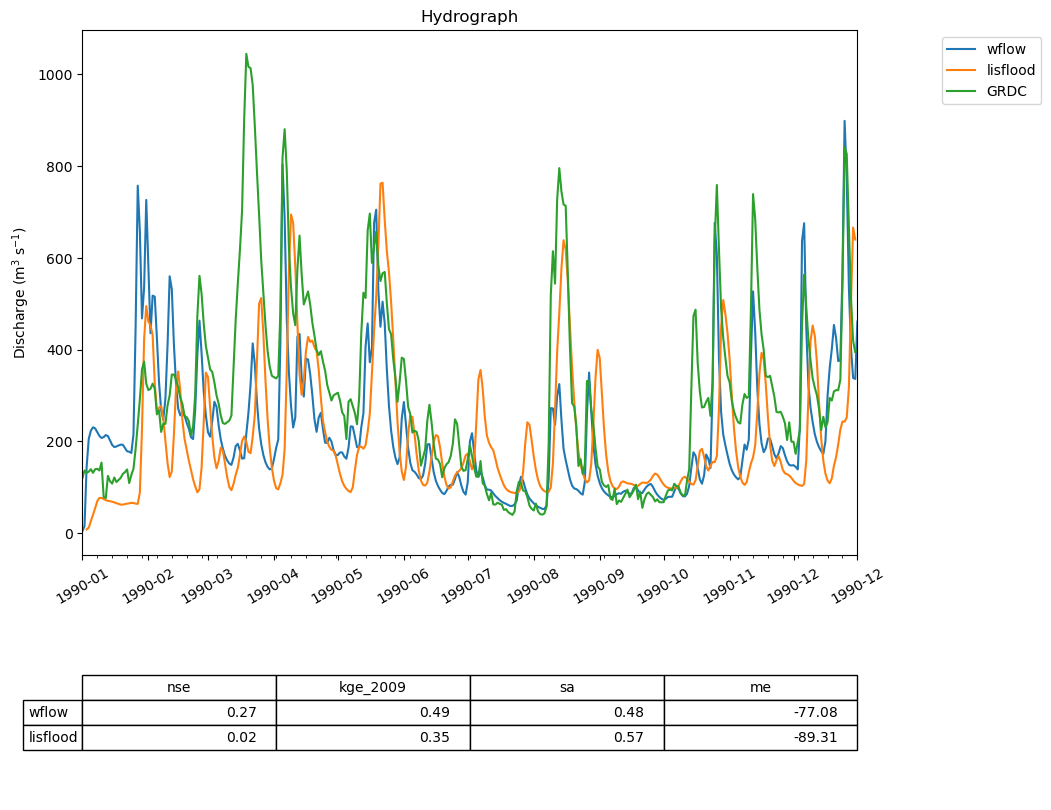

In [41]:
# Combine simulated and observed values to one dataframe according to time axis
hydro_data = pd.concat([wflow, lisflood, observations], axis=1)

# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='GRDC', filename = 'figures/case2_HelloWorldsHydrograph.png')